## import packages and intake catalog

In [1]:
#
# Import packages
#
import numpy as np
import xarray as xr
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import colorcet as cc

from pathlib import Path
import itertools

from intake import open_catalog

import warnings
warnings.simplefilter('ignore',  xr.SerializationWarning)

In [2]:
#open the catalog and experiment info
cat_dir = Path('C:/Users/elayton/Desktop/RFMIP/RFMIP-rad-irf-intake-main')
cat = open_catalog(cat_dir.joinpath("main.yml"))
# 
# Problem specification including experiement names goes into "extrainfo"
#
extrainfo = cat.inputs.to_dask()

## Data preparation

In [3]:
def get_all_cols(catalog, realization=0):
    #
    # Create a dataset with all rad-irf data 
    #
    # Some benchmark models don't have SW fields.  
    #    Accumulate LW and SW fields separately, then assign the SW to the LW
    #
    lw_models = [m for m in list(catalog) if "fourAOP" not in m]
    #
    # Nested concatenation - inner concat is over models, outer concat over fields 
    #   While building dataset provide experiement names as coordinate and omit unneeded variable
    #   
    #
    lw = xr.concat([xr.concat([catalog[m][list(catalog[m])[realization]][f].to_dask() 
                                     for m in lw_models], dim="model").assign_coords(model=lw_models)
                         for f in ["rlu", "rld"]],  dim="field", data_vars = "different"
    ).assign_coords(expt=extrainfo['expt_label']).drop_vars(["plev"])

    sw_models = [m for m in list(catalog) if "rsu" in catalog[m][list(catalog[m])[realization]]]
    sw = xr.concat([xr.concat([catalog[m][list(catalog[m])[realization]][f].to_dask() 
                                     for m in sw_models], dim="model").assign_coords(model=sw_models)
                         for f in ["rsu", "rsd"]],  dim="field", data_vars = "different"
    ).assign_coords(expt=extrainfo['expt_label']).drop_vars(["plev"])
    #
    # RRTMGP shortwave values are reversed in the vertical 
    #    Maybe there are nicer ways to reindex 
    #
    if "RRTMG" in sw_models: 
        i = list(sw_models).index("RRTMG")
        # Dimensions are model, expt, site, level
        for v in ["rsd", "rsu"]: 
            sw[v][i,:,:,:] = sw[v][i,:,:,::-1]
            
    lw["rsu"] = sw["rsu"]
    lw["rsd"] = sw["rsd"]
    lw["rln"] = lw["rld"] - lw["rlu"]
    lw["rsn"] = lw["rsd"] - lw["rsu"]
    return(lw)


## Computing global-mean CO2 forcing

In [4]:
def co2_forcing(ds):
    expts = sorted([e for e in ds.expt.values if "CO2"[0:] in e and e != "PI CO2"])
    return(ds.sel(expt=expts) - ds.sel(expt="PI CO2"))

def global_mean(ds): 
    return(ds.weighted(weights=ds.profile_weight).mean(dim="site").drop_vars("profile_weight"))

#
# Come back to this: co2_forcing(global_mean()) works but global_mean(co2_forcing()) produces NAs
#

In [5]:
parameterized = get_all_cols(cat.parameterized)
benchmark     = get_all_cols(cat.benchmark)

TOA = 0 
SFC = parameterized.level.values.max()

# Values of CO2 multipliers for the experiements 
co2_factors = [float(s.replace("xCO2", "")) for s in co2_forcing(benchmark).expt.values]

co2_forcing(global_mean(benchmark))

<xarray.Dataset>
Dimensions:  (model: 5, expt: 5, level: 61)
Coordinates:
  * model    (model) <U10 'LBLRTM' 'ARTS' 'HadGEM3' 'GRTCODE' 'RFM_DISORT'
  * expt     (expt) object '0.5xCO2' '2xCO2' '3xCO2' '4xCO2' '8xCO2'
Dimensions without coordinates: level
Data variables:
    rld      (model, expt, level) float32 0.0 -0.04546 -0.08756 ... 7.101 7.153
    rlu      (model, expt, level) float32 2.715 2.702 2.69 ... -0.1089 0.1431
    rsu      (model, expt, level) float32 0.05108 0.05107 ... -0.2186 -0.2186
    rsd      (model, expt, level) float32 0.0 0.004883 ... -1.652 -1.651
    rln      (model, expt, level) float32 -2.715 -2.747 -2.778 ... 7.209 7.01
    rsn      (model, expt, level) float32 -0.05103 -0.04626 ... -1.433 -1.432

In [6]:
#
# Can iterate through {LW, SW} x {TOA, SFC} and see that results are pretty close to 2020 paper 
#    which uses mean across realizations rather than one realization per model
#
co2_forcing(global_mean(benchmark)).isel(level=[TOA, SFC])

<xarray.Dataset>
Dimensions:  (model: 5, expt: 5, level: 2)
Coordinates:
  * model    (model) <U10 'LBLRTM' 'ARTS' 'HadGEM3' 'GRTCODE' 'RFM_DISORT'
  * expt     (expt) object '0.5xCO2' '2xCO2' '3xCO2' '4xCO2' '8xCO2'
Dimensions without coordinates: level
Data variables:
    rld      (model, expt, level) float32 0.0 -1.849 0.0 ... 4.353 0.0 7.153
    rlu      (model, expt, level) float32 2.715 -0.0369 -2.742 ... -8.092 0.1431
    rsu      (model, expt, level) float32 0.05108 0.04458 ... -0.245 -0.2186
    rsd      (model, expt, level) float32 0.0 0.3277 0.0 ... -0.9683 0.0 -1.651
    rln      (model, expt, level) float32 -2.715 -1.812 2.742 ... 8.092 7.01
    rsn      (model, expt, level) float32 -0.05103 0.2832 ... 0.2451 -1.432

# Plots

In [7]:
pal    = cc.b_glasbey_bw
param_cols = {m:pal[i+1]                                 for i, m in enumerate(parameterized.model.values)}    
bench_cols = {m:pal[i+1+len(parameterized.model.values)] for i, m in enumerate(benchmark.model.values)}    

### Benchmark forcing - plot values from 2020 paper table. This is Figure 1? 

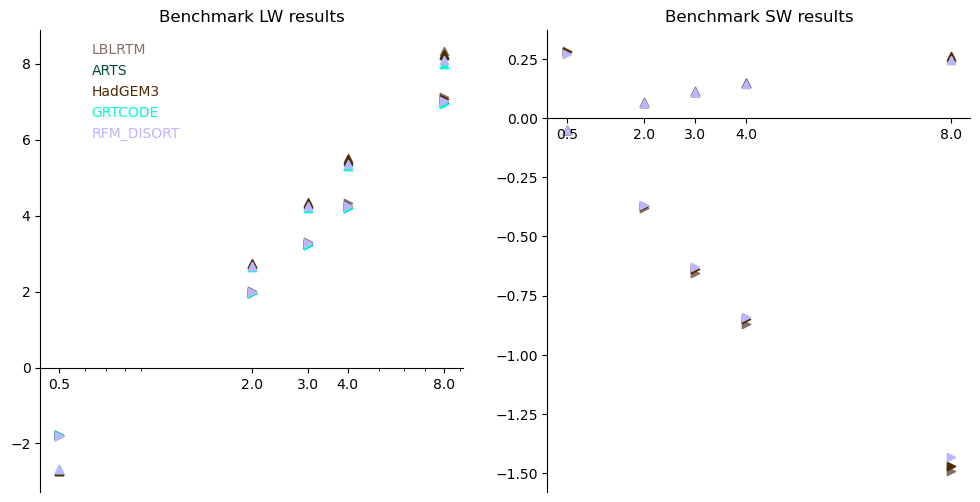

In [8]:
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(ncols=2)
for c,v in enumerate(["rln", "rsn"]):
    for m in benchmark.model: 
        if not (m == "GRTCODE" and "rs" in v):
            axes[c].scatter(co2_factors, 
                    co2_forcing(global_mean(benchmark)).sel(model=m).isel(level=TOA)[v], 
                    marker = "^",
                    c = bench_cols[str(m.values)], 
                    label=m.values
                   )

    for m in benchmark.model: 
        if not (m == "GRTCODE" and "rs" in v): 
            axes[c].scatter(co2_factors, 
                        co2_forcing(global_mean(benchmark)).sel(model=m).isel(level=SFC)[v], 
                        c = bench_cols[str(m.values)], 
                        marker = ">")

    if "rl" in v: axes[c].set_xscale("log")
    axes[c].spines[['bottom']].set_position('zero')
    axes[c].spines[['top', 'right']].set_visible(False)
    axes[c].set_xticks(co2_factors)
    axes[c].set_xticklabels(co2_factors)
    axes[c].set_title(f'Benchmark {"LW" if v == "rln" else "SW"} results')

axes[0].legend(frameon = False, 
               labelcolor=[c for c in bench_cols.values()], 
               markerscale=0) 


#
# To refine - colors map to particular models (need two sets)
#   markers? to reflect TOA/SFC
#   Better formatting of tick labels? 
#   Refine legend? 
#   Refine colors? 
#   Draw least-squares lines? 
#

## On picking a benchmark

GRTCODE's SW forcing is 2x LBL and RFM, which agree quite well. Omit in SW

### What about LBLRTM? 

Do it have one fewer columns than others? Does this impact forcing, so won't want to use as a reference?  

## Computing errors 

In [9]:
# benchmark model is LBLRTM despite not being sure if SW has one fewer column than others 
m0 = "HadGEM3"
co2_forcing_err = co2_forcing(global_mean(parameterized)) - co2_forcing(global_mean(benchmark.sel(model=m0)))

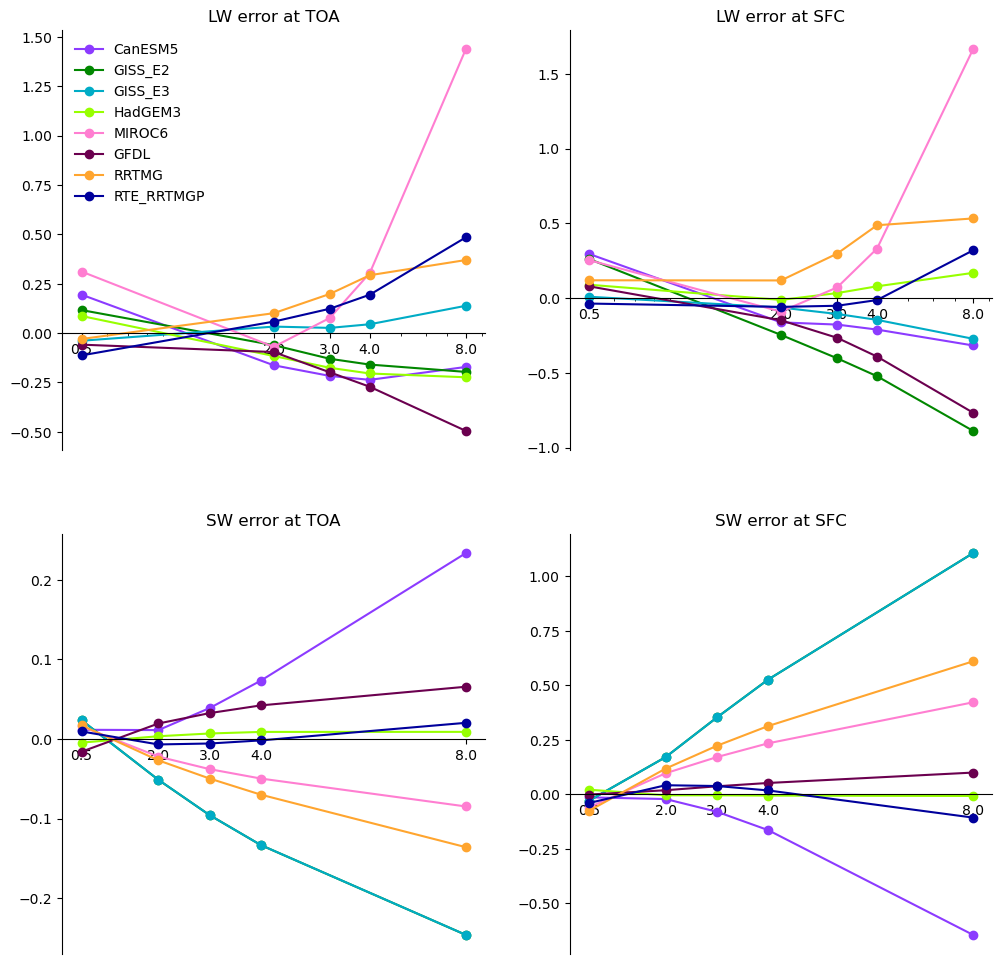

In [10]:
#
# Error as a function of concentration 
#
fig = plt.figure(figsize=(12, 12))
axes = fig.subplots(nrows=2, ncols=2)
for (r, v), (c, l) in list(itertools.product(enumerate(["rln", "rsn"]), enumerate([TOA, SFC]))): 
    for m in co2_forcing_err.model: 
        axes[r][c].plot(co2_factors, 
                        co2_forcing_err.sel(model=m).isel(level=l)[v], 
                        "-o", 
                        c = param_cols[str(m.values)], 
                        label=m.values
                        )
        axes[r][c].spines[['bottom']].set_position('zero')
        axes[r][c].spines[['top', 'right']].set_visible(False)
        axes[r][c].set_title(f'{"LW" if v == "rln" else "SW"} error at {"TOA" if l == TOA else "SFC"}')
        # Log x scale for LW 
        if "rl" in v: axes[r][c].set_xscale("log")
        axes[r][c].set_xticks(co2_factors)
        axes[r][c].set_xticklabels(co2_factors)

axes[0][0].legend(frameon=False) #markerscale=.5, markerfirst = False)


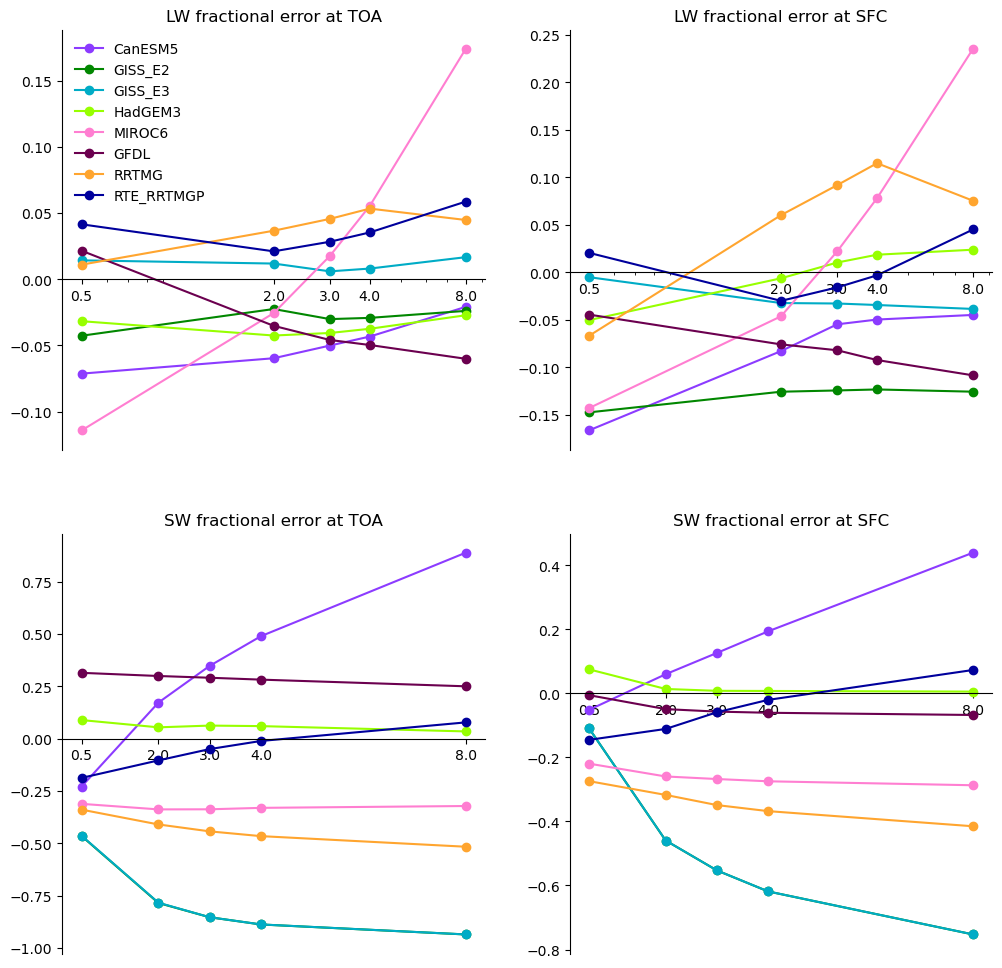

In [11]:
#
# Fractional error as a function of concentration 
#
fig = plt.figure(figsize=(12, 12))
axes = fig.subplots(nrows=2, ncols=2)

frac_error = co2_forcing_err/co2_forcing(global_mean(benchmark.sel(model=m0)))

for (r, v), (c, l) in list(itertools.product(enumerate(["rln", "rsn"]), enumerate([TOA, SFC]))): 
    for m in co2_forcing_err.model: 
        axes[r][c].plot(co2_factors, 
                        frac_error.sel(model=m).isel(level=l)[v], 
                        "-o",
                        c = param_cols[str(m.values)], 
                        label=m.values
                        )
        axes[r][c].spines[['bottom']].set_position('zero')
        axes[r][c].spines[['top', 'right']].set_visible(False)
        axes[r][c].set_title(f'{"LW" if v == "rln" else "SW"} fractional error at {"TOA" if l == TOA else "SFC"}')
        # Log x scale for LW 
        if "rl" in v: axes[r][c].set_xscale("log")
        axes[r][c].set_xticks(co2_factors)
        axes[r][c].set_xticklabels(co2_factors)
axes[0][0].legend(frameon=False)


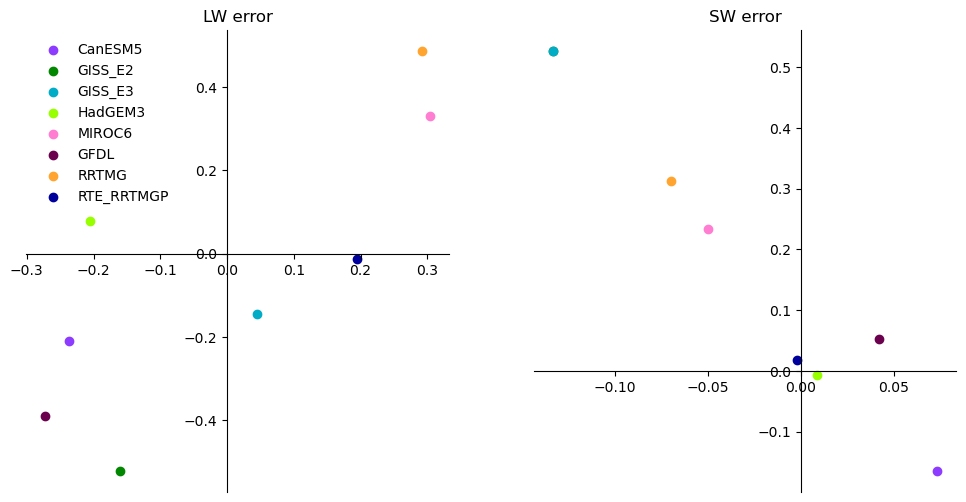

In [12]:
#
# Error at top-of-atmophere vs error at surface for a single experiment  
#
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(ncols=2)
for c,v in enumerate(["rln", "rsn"]):
    for m in co2_forcing_err.model: 
        axes[c].scatter(co2_forcing_err.sel(model=m, expt="4xCO2").isel(level=TOA)[v], 
                        co2_forcing_err.sel(model=m, expt="4xCO2").isel(level=SFC)[v], 
                        c = param_cols[str(m.values)], 
                        label=m.values)
    axes[c].spines[['left', 'bottom']].set_position('zero')
    axes[c].spines[['top', 'right']].set_visible(False)
    axes[c].set_title(f'{"LW" if v == "rln" else "SW"} error')
axes[0].legend(frameon = False)

#
# Axis labels 
#

### GFDL SW results in the next plot are pretty confusing. 

How is forcing overestimated at both surface and TOA, given that the forcings themselves are of opposite sign?  

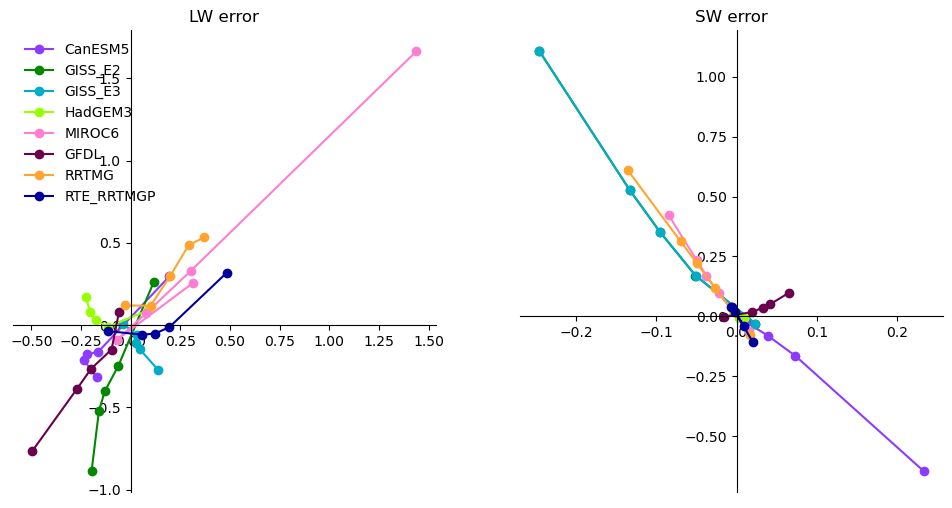

In [13]:
#
# Error at top-of-atmophere vs error at surface for a single experiment
#   What about lines for each model? 
#
fig = plt.figure(figsize=(12, 6))
axes = fig.subplots(ncols=2)
for c,v in enumerate(["rln", "rsn"]):
    for m in co2_forcing_err.model: 
        axes[c].plot(co2_forcing_err[v].sel(model=m).isel(level=TOA), 
                     co2_forcing_err[v].sel(model=m).isel(level=SFC), 
                     "-o", 
                     c = param_cols[str(m.values)], 
                     label = m.values)
    axes[c].spines[['left', 'bottom']].set_position('zero')
    axes[c].spines[['top', 'right']].set_visible(False)
    axes[c].set_title(f'{"LW" if v == "rln" else "SW"} error')
             
axes[0].legend(frameon = False)


Text(1, 1.0, '')

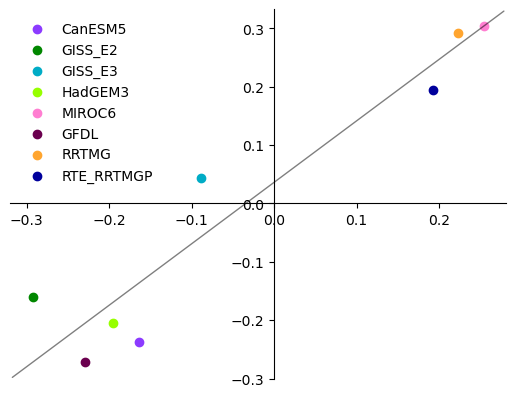

In [14]:
# What about a figure to show that the distribution of errors across an experiement? 
#   A straight histogram is a bit boring... plot the total vs one error? 
#
# Total error as a function of LW error at TOA - not so interesting because the errors are dominated by LW 
#
fig, ax = plt.subplots()

for m in co2_forcing_err.model: 
    ax.scatter(co2_forcing_err["rln"].isel(level=TOA).sel(expt="4xCO2",model=m) + 
               co2_forcing_err["rsn"].isel(level=TOA).sel(expt="4xCO2",model=m), 
               co2_forcing_err["rln"].isel(level=TOA).sel(expt="4xCO2",model=m), 
               c = param_cols[str(m.values)], 
               label=m.values)
ax.legend(frameon=False)
ax.spines[['left', 'bottom']].set_position('zero')
ax.spines[['top', 'right']].set_visible(False)
#
# Add a 1:1 line. The below isn't right, we'll have to find min/max of x, y
#
ax.annotate("",
            xy=(0., 0.),    xycoords=ax,
            xytext=(1, 1.), textcoords=ax,
            arrowprops=dict(arrowstyle="-", alpha = 0.5),
            )
